# intro to keras and neural networks on MNiST


In [1]:
#standard library imports...
from math import *
import os
import random

# classics
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sb

#suppresses scientific notation in numpy because i find it hard to look at
np.set_printoptions(suppress=True)

# i'll hold off on keras imports so we can see them as we go.

let's have a look at the data, here's how i've laid out my directories:


In [2]:
%mkdir models

mkdir: models: File exists


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/train.csv')
train.shape

(42000, 785)

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.values.shape

(42000, 785)

so here we have 42000 28 x 28 images flattened into a single dimension.
this is an insane way of structuring image data but it will make us appreciate the beauty of convnets and taking advantage of image sturcture later. So first we can look at the most basic kind of network, the **fully-connected** network using this flat data.

In [6]:
# seperate out our data and labels (label is the first column in the dataframe)
X, y = train.values[:, 1:], train.values[:, 0]
X = X.astype('float32') #keras likes a 32 bit float


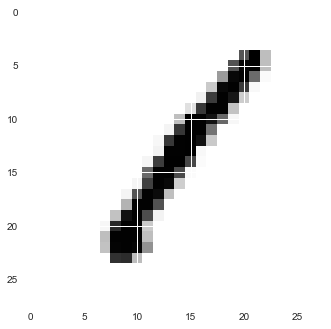

In [7]:
ex = X[0].reshape(28, 28)
plt.imshow(ex)
plt.show()

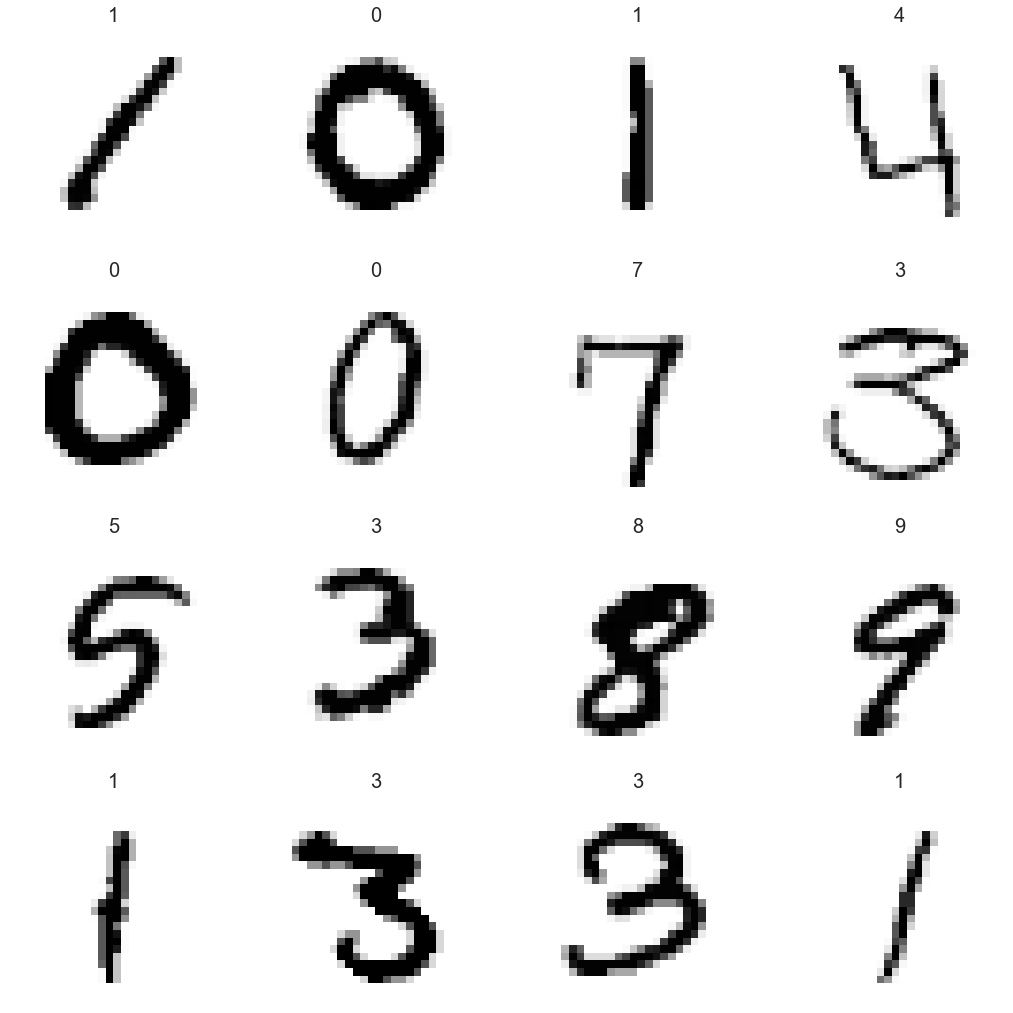

In [8]:
# convince ourselves these flat arrays are actually images of digits
fig, axes = plt.subplots(4, 4, figsize=(18, 18))

for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(X[i].reshape(28, 28))
    ax.set_title(y[i], fontsize=20)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

# softmax
---

in classification we use the softmax function:
$$S(Yi)=eyi∑jeyj$$
 
this squashes scores into proper probabilities (sum to one). So it follows that this function is only appropriate where we have a single correct class label, for multilabel classification we would use sigmoid.

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


#where each columns represent a sample and eac row a class score
scores = np.array([[1, 2, 3, 6],
                   [2, 4, 5, 6],
                   [3, 8, 7, 6]])

softmax(scores)

array([[ 0.09003057,  0.00242826,  0.01587624,  0.33333333],
       [ 0.24472847,  0.01794253,  0.11731043,  0.33333333],
       [ 0.66524096,  0.97962921,  0.86681333,  0.33333333]])

In [12]:
#often we'd be looking at this row wise so..
softmax(scores).T

array([[ 0.09003057,  0.24472847,  0.66524096],
       [ 0.00242826,  0.01794253,  0.97962921],
       [ 0.01587624,  0.11731043,  0.86681333],
       [ 0.33333333,  0.33333333,  0.33333333]])

###### what happens when we raise increase the values of our globally across all samples?

In [13]:
scores = np.array([3.0, 1.0, 2.0])
print('before increase:\n', softmax(scores))
print('after increase:\n', softmax(scores*10))

before increase:
 [ 0.66524096  0.09003057  0.24472847]
after increase:
 [ 0.9999546  0.         0.0000454]


- the classifier becomes very confident about it's predictions.

###### and if we divide by 10 across all samples?

In [14]:
print('before decrease:\n', softmax(scores))
print('after decrease:\n', softmax(scores/10))

before decrease:
 [ 0.66524096  0.09003057  0.24472847]
after decrease:
 [ 0.3671654   0.30060961  0.33222499]


- probabilities get closer to uniform distribution

# one hot encoding

---

a softmax classifier wants labels in the same form that it outputs probabilites. It needs an array of shape : `(n_samples, n_classes)` with true labels as `0` and all other labels as `1`. this is called one-hot encoding. if we had the labels for example if we had the labels:

`[0, 2, 2]`

we would one hot encode as:

`[0, 1, 0], [0, 0, 1], [0, 0, 1]`

pandas and keras both make this easy:

to our labels in pandas:

In [15]:
pd.get_dummies(y).head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


in keras you can use `to_categorical`:

In [9]:
from keras.utils import to_categorical

y = to_categorical(y)
y


Using TensorFlow backend.


array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

#### we minimize use the cross entropy loss averaged across all samples

for categorization in keras this loss function is called `categorical_crossentropy`

# center and standardize inputs!

this is an important one! for numerical stability and in order not to fuck up the world when using ReLUs we want to get our inputs to roughly a mean of 0. this can be done by subtracting the mean of the training data across the depth channel. 

optionally can further standardize by dividing by standard deviation. 

in our case we have a flat array with 1 channel so we can do this a bit more simply for now:

In [10]:
M, S = X.mean(), X.std()

X -=  M
X /= S
X.mean(), X.std()

(-4.9268539e-07, 1.0000043)

# train a linear model in keras



In [16]:
# for plotting training history
def plot_history(model_history):
    fig, axes = plt.subplots(1, 2, figsize = (20, 10))
    h = model_history.history
    a1, a2 = axes
    # summarize history for accuracy
    a1.plot(h['acc'])
    a1.plot(h['val_acc'])
    a1.set_title('model accuracy')

    # summarize history for loss
    a2.plot(h['loss'])
    a2.plot(h['val_loss'])
    a2.set_title('model loss')

    plt.ylabel('accuracy/ loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

declare the number of classes and out input shape

In [13]:
n_classes =10
input_shape = (X.shape[1])

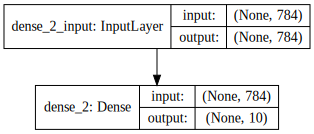

In [18]:
#initialize squential model
linear_model = Sequential()

# add a single linear dense layer with the output shape of our classes
linear_model.add(Dense(n_classes, 
                       activation='softmax', 
                       input_shape=(input_shape,)))

# compile model using categorical_cross entropy loss and sgd
linear_model.compile(loss='categorical_crossentropy', 
                     metrics=['acc'], optimizer='sgd')

SVG(model_to_dot(linear_model, show_shapes=True).create(prog='dot', format='svg'))

Train on 29399 samples, validate on 12601 samples
Epoch 1/30
29399/29399 [==============================] - 10s - loss: 0.5153 - acc: 0.8468 - val_loss: 0.3616 - val_acc: 0.8948
Epoch 2/30
29399/29399 [==============================] - 8s - loss: 0.3419 - acc: 0.9004 - val_loss: 0.3262 - val_acc: 0.9055
Epoch 3/30
29399/29399 [==============================] - 9s - loss: 0.3157 - acc: 0.9091 - val_loss: 0.3115 - val_acc: 0.9107
Epoch 4/30
29399/29399 [==============================] - 8s - loss: 0.3017 - acc: 0.9135 - val_loss: 0.3023 - val_acc: 0.9114
Epoch 5/30
29399/29399 [==============================] - 9s - loss: 0.2920 - acc: 0.9169 - val_loss: 0.3003 - val_acc: 0.9125
Epoch 6/30
29399/29399 [==============================] - 8s - loss: 0.2849 - acc: 0.9185 - val_loss: 0.2957 - val_acc: 0.9148
Epoch 7/30
29399/29399 [==============================] - 9s - loss: 0.2800 - acc: 0.9201 - val_loss: 0.2917 - val_acc: 0.9171
Epoch 8/30
29399/29399 [==============================] - 8s

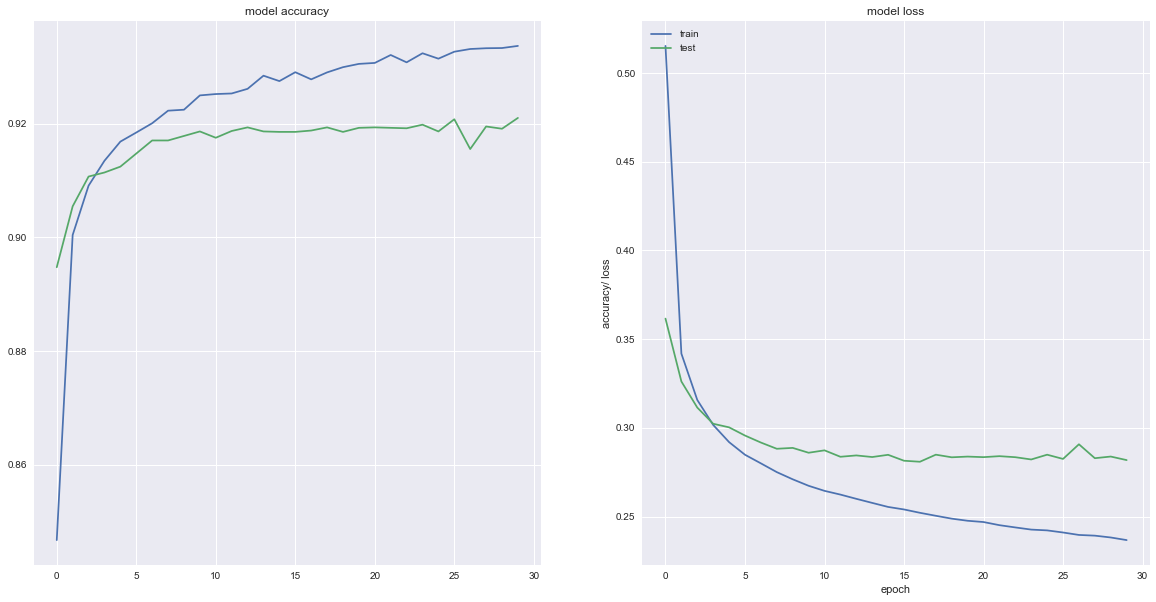

In [19]:
hist = linear_model.fit(X, y, validation_split=.3, batch_size=32, epochs=30)
plot_history(hist)

one thing to note is that our training loss is not very far from our validation loss. In this simple linear model we don't have the capacity to learn complex features.

# ReLu and  hidden layers
linear models are not that great most nns use the ReLU (rectified linear unit) non linearity soo simple:

linear if `x > 0` else `0`

we also add a single hidden dense layer 

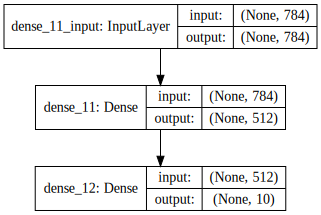

In [29]:
#initialize squential model
model = Sequential()

# add a single hidden layer  of size with a relu activation
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))

# our output layer
model.add(Dense(n_classes, activation='softmax'))
# compile model using categorical_cross entropy loss and sgd
model.compile(loss='categorical_crossentropy', 
                     metrics=['acc'], optimizer='sgd')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Train on 29399 samples, validate on 12601 samples
Epoch 1/30
29399/29399 [==============================] - 9s - loss: 0.4142 - acc: 0.8802 - val_loss: 0.2631 - val_acc: 0.9256
Epoch 2/30
29399/29399 [==============================] - 9s - loss: 0.2312 - acc: 0.9334 - val_loss: 0.2113 - val_acc: 0.9394
Epoch 3/30
29399/29399 [==============================] - 8s - loss: 0.1842 - acc: 0.9488 - val_loss: 0.1848 - val_acc: 0.9467
Epoch 4/30
29399/29399 [==============================] - 8s - loss: 0.1547 - acc: 0.9566 - val_loss: 0.1628 - val_acc: 0.9532
Epoch 5/30
29399/29399 [==============================] - 9s - loss: 0.1328 - acc: 0.9648 - val_loss: 0.1482 - val_acc: 0.9559
Epoch 6/30
29399/29399 [==============================] - 9s - loss: 0.1164 - acc: 0.9692 - val_loss: 0.1392 - val_acc: 0.9600
Epoch 7/30
29399/29399 [==============================] - 8s - loss: 0.1027 - acc: 0.9734 - val_loss: 0.1310 - val_acc: 0.9617
Epoch 8/30
29399/29399 [==============================] - 9s 

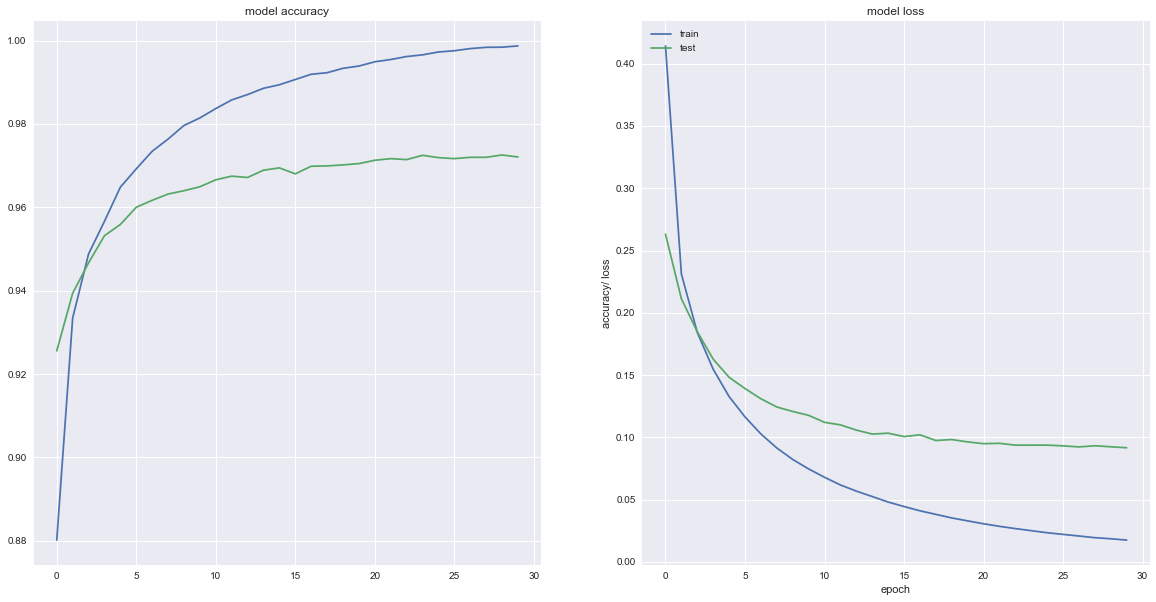

In [31]:
hist = model.fit(X, y, validation_split=.3, epochs=30)
plot_history(hist)

try adding a second dense layer

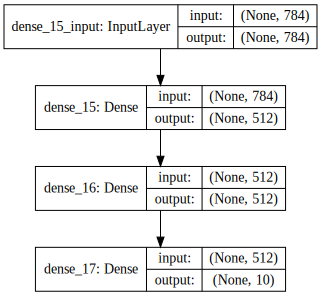

In [34]:
#initialize squential model
model = Sequential()

# add a single hidden layer  of size with a relu activation
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(Dense(512, activation='relu'))

# our output layer
model.add(Dense(n_classes, activation='softmax'))
# compile model using categorical_cross entropy loss and sgd
model.compile(loss='categorical_crossentropy', 
                     metrics=['acc'], optimizer='sgd')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

a in a dense layer all units are connected to all input units this will add quite a lot of parameters. Adding parameters will increase the capacity of our model but 

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Train on 29399 samples, validate on 12601 samples
Epoch 1/30
29399/29399 [==============================] - 13s - loss: 0.4200 - acc: 0.8795 - val_loss: 0.2462 - val_acc: 0.9272
Epoch 2/30
29399/29399 [==============================] - 12s - loss: 0.2075 - acc: 0.9379 - val_loss: 0.1877 - val_acc: 0.9446
Epoch 3/30
29399/29399 [==============================] - 12s - loss: 0.1555 - acc: 0.9555 - val_loss: 0.1606 - val_acc: 0.9528
Epoch 4/30
29399/29399 [==============================] - 12s - loss: 0.1246 - acc: 0.9645 - val_loss: 0.1405 - val_acc: 0.9579
Epoch 5/30
29399/29399 [==============================] - 12s - loss: 0.1033 - acc: 0.9721 - val_loss: 0.1277 - val_acc: 0.9610
Epoch 6/30
29399/29399 [==============================] - 12s - loss: 0.0868 - acc: 0.9766 - val_loss: 0.1245 - val_acc: 0.9626
Epoch 7/30
29399/29399 [==============================] - 12s - loss: 0.0741 - acc: 0.9808 - val_loss: 0.1152 - val_acc: 0.9638
Epoch 8/30
29399/29399 [==============================

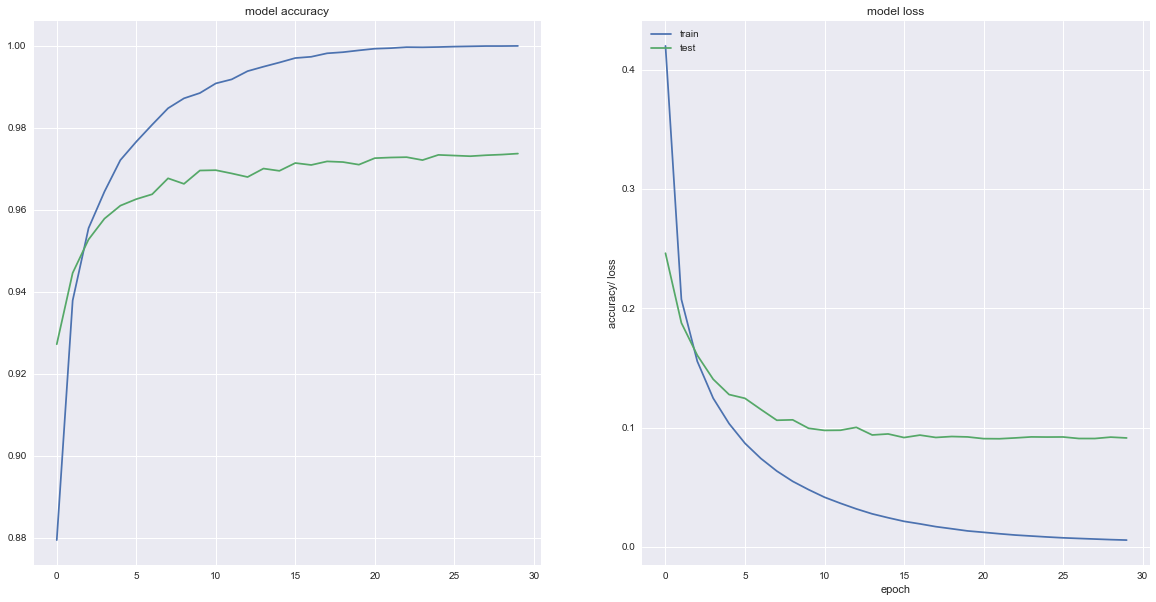

In [36]:
hist = model.fit(X, y, validation_split=.3, epochs=30)
plot_history(hist)

the fact that we can fully overfit the training data indicates that our initilization is sensible, there's nothing wrong with our labels etc.


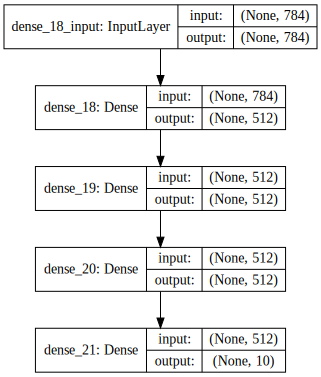

In [37]:

#initialize squential model
model = Sequential()

# add a single hidden layer  of size with a relu activation
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))


# our output layer
model.add(Dense(n_classes, activation='softmax'))
# compile model using categorical_cross entropy loss and sgd
model.compile(loss='categorical_crossentropy', 
                     metrics=['acc'], optimizer='sgd')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Train on 29399 samples, validate on 12601 samples
Epoch 1/10
29399/29399 [==============================] - 25s - loss: 0.2606 - acc: 0.9207 - val_loss: 0.1991 - val_acc: 0.9393
Epoch 2/10
29399/29399 [==============================] - 22s - loss: 0.1255 - acc: 0.9620 - val_loss: 0.1218 - val_acc: 0.9656
Epoch 3/10
29399/29399 [==============================] - 22s - loss: 0.0944 - acc: 0.9709 - val_loss: 0.1401 - val_acc: 0.9593
Epoch 4/10
29399/29399 [==============================] - 22s - loss: 0.0791 - acc: 0.9755 - val_loss: 0.1426 - val_acc: 0.9628
Epoch 5/10
29399/29399 [==============================] - 22s - loss: 0.0617 - acc: 0.9819 - val_loss: 0.1472 - val_acc: 0.9646
Epoch 6/10
29399/29399 [==============================] - 22s - loss: 0.0544 - acc: 0.9835 - val_loss: 0.1547 - val_acc: 0.9628
Epoch 7/10
29399/29399 [==============================] - 21s - loss: 0.0474 - acc: 0.9855 - val_loss: 0.1264 - val_acc: 0.9698
Epoch 8/10
29399/29399 [==============================

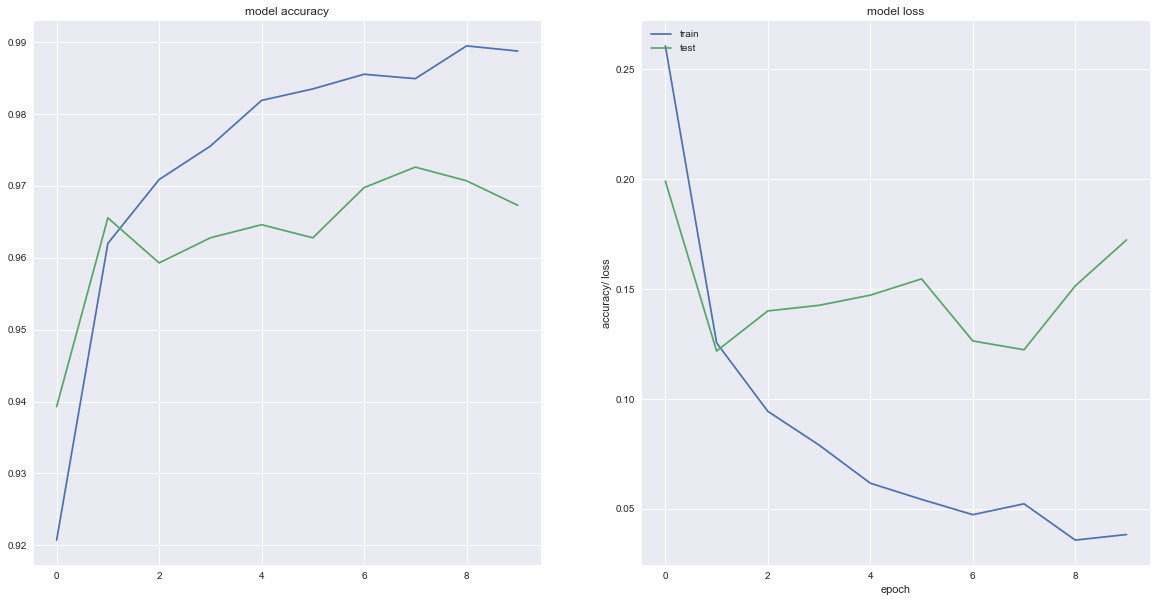

In [46]:
hist = model.fit(X, y, validation_split=.3, epochs=10)
plot_history(hist)

now we are serously overfitting. in dense layers every node is connected to every other node so we can coun't on them overfitting. we can try adding some dropout between each layer 

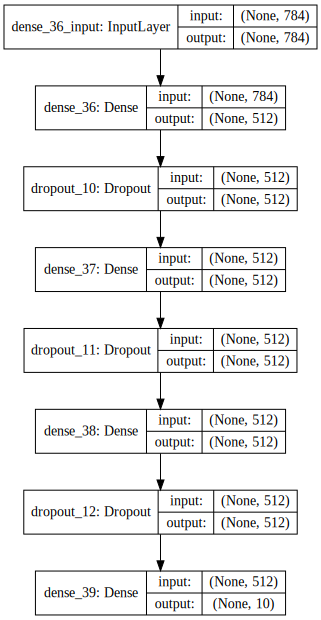

In [47]:
from keras.layers import Dropout
#initialize squential model
model = Sequential()

# add a single hidden layer  of size with a relu activation
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(Dropout(.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))



# our output layer
model.add(Dense(n_classes, activation='softmax'))
# compile model using categorical_cross entropy loss and sgd
model.compile(loss='categorical_crossentropy', 
                     metrics=['acc'], optimizer='adam')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Train on 29399 samples, validate on 12601 samples
Epoch 1/30
29399/29399 [==============================] - 25s - loss: 0.3290 - acc: 0.8972 - val_loss: 0.1688 - val_acc: 0.9488
Epoch 2/30
29399/29399 [==============================] - 23s - loss: 0.1736 - acc: 0.9481 - val_loss: 0.1620 - val_acc: 0.9495
Epoch 3/30
29399/29399 [==============================] - 24s - loss: 0.1398 - acc: 0.9579 - val_loss: 0.1413 - val_acc: 0.9630
Epoch 4/30
29399/29399 [==============================] - 24s - loss: 0.1174 - acc: 0.9651 - val_loss: 0.1335 - val_acc: 0.9638
Epoch 5/30
29399/29399 [==============================] - 24s - loss: 0.1101 - acc: 0.9679 - val_loss: 0.1210 - val_acc: 0.9683
Epoch 6/30
29399/29399 [==============================] - 24s - loss: 0.1020 - acc: 0.9696 - val_loss: 0.1147 - val_acc: 0.9693
Epoch 7/30
29399/29399 [==============================] - 22s - loss: 0.0912 - acc: 0.9730 - val_loss: 0.1330 - val_acc: 0.9669.
Epoch 8/30
29399/29399 [=============================

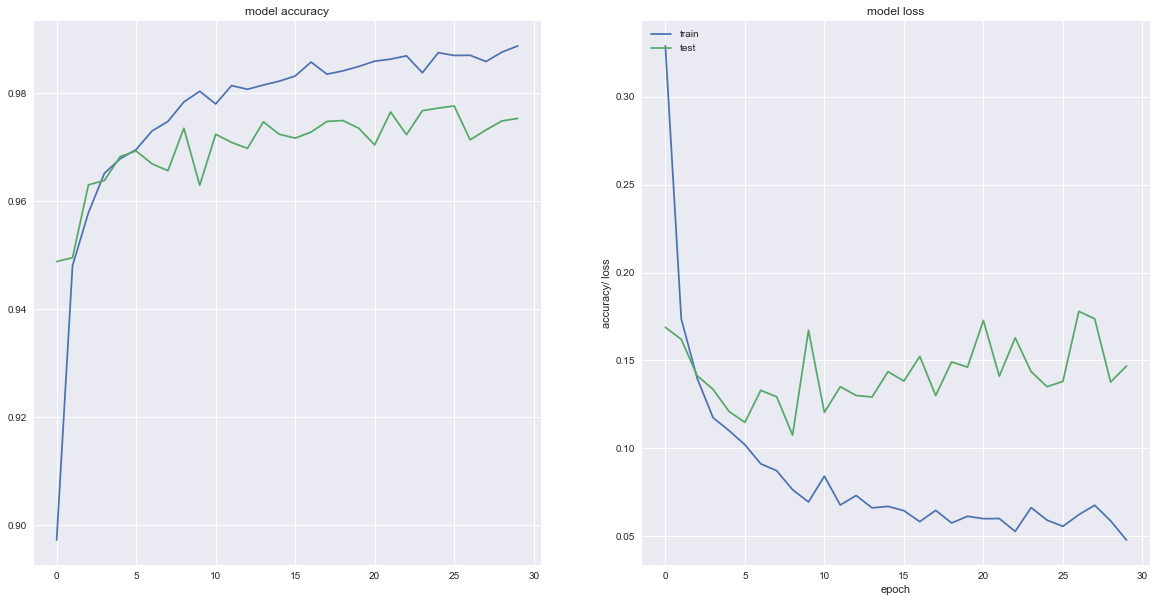

In [48]:
hist = model.fit(X, y, validation_split=.3, epochs=30)
plot_history(hist)